# Training Convolutional Autoencoders

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from time import time
import mplcyberpunk as cp
%matplotlib inline
plt.style.use('../dark-custom.mplstyle')

In [2]:
import sys
sys.path.append('..')
from ModelClasses.Autoencoders import (
    DenseAutoencoder, DenseEncoder,
    ConvolutionalAutoencoder, ConvolutionalEncoder
)
from Utils import (
    autoencoder_train_loop,
    plot_loss,
    compare_generated_to_original_mnist,
    get_latent_space_points,
    get_dict_of_latent_spaces,
    compare_latent_spaces,
    zoom_limits
)

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training the Autoencoder

Let's see how the number of channels in encoder affects

In [4]:
DATA_PATH = '../Datasets/data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])
mnist_train = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)

In [5]:
INPUT_SHAPE = [1, 28, 28]
LEARNING_RATE = 0.002
BATCH_SIZE = 512
NUM_EPOCHS = 25
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

num_filters_list = [2, 8, 16, 32, 64, 128]
kernel_size = 3
stride = 1
latent_space_dim = 2

In [6]:
loss_results = {}
trained_models = {}
model_path = './models/9.2-ConvolutionalAutoencoders/'
for num_filters in num_filters_list:
    architecture = [num_filters, latent_space_dim]
    print(f'{architecture}')
    
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=[num_filters],
        convolutional_kernels=[kernel_size],
        convolutional_strides=[stride],
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[2, 2]


100%|██████████| 25/25 [04:14<00:00, 10.17s/it, loss=0.68] 


[8, 2]


100%|██████████| 25/25 [04:22<00:00, 10.49s/it, loss=0.651]


[16, 2]


100%|██████████| 25/25 [04:15<00:00, 10.22s/it, loss=0.714]


[32, 2]


100%|██████████| 25/25 [04:19<00:00, 10.38s/it, loss=0.707]


[64, 2]


100%|██████████| 25/25 [04:25<00:00, 10.62s/it, loss=0.709]


[128, 2]


100%|██████████| 25/25 [05:08<00:00, 12.36s/it, loss=0.724]


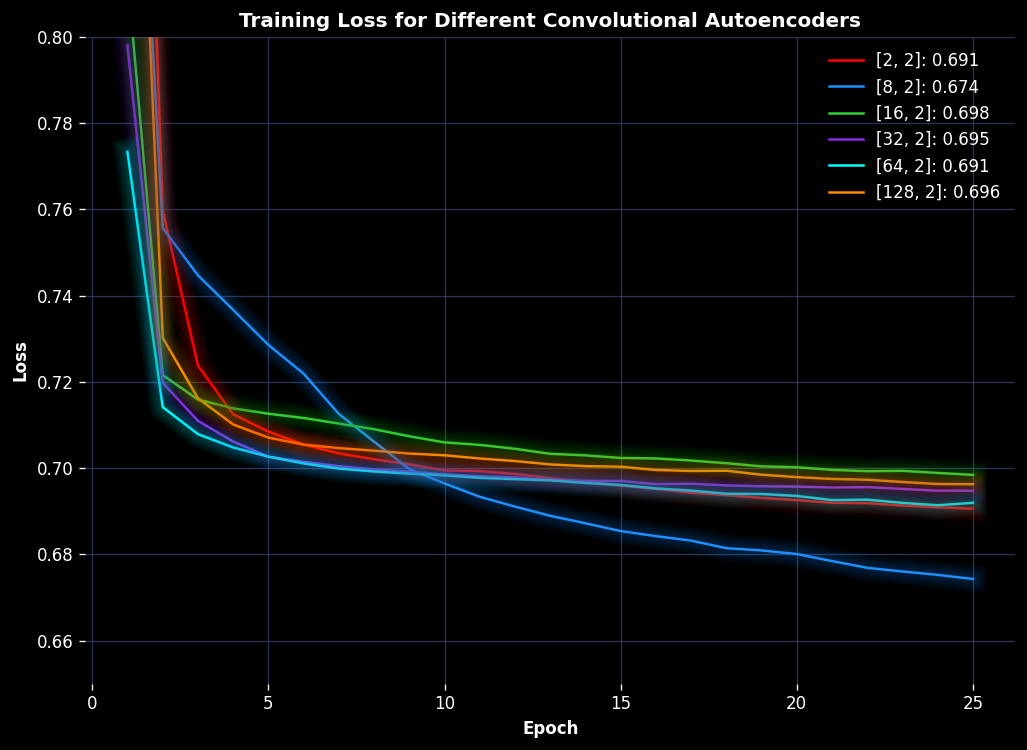

In [7]:
figure, axes = plt.subplots(1, 1, figsize=(10, 7))
config = dict(ylim=[0.65, 0.8])
plot_loss(epochs=NUM_EPOCHS,
          loss_dict=loss_results,
          config_dict=config,
          title=f'Training Loss for Different Convolutional Autoencoders',
          ax=axes)
cp.make_lines_glow(ax=axes, n_glow_lines=15)
figure.savefig('./images/9.2_image_1.png');

We can see that the bottleneck is likely to be the latent space dimension

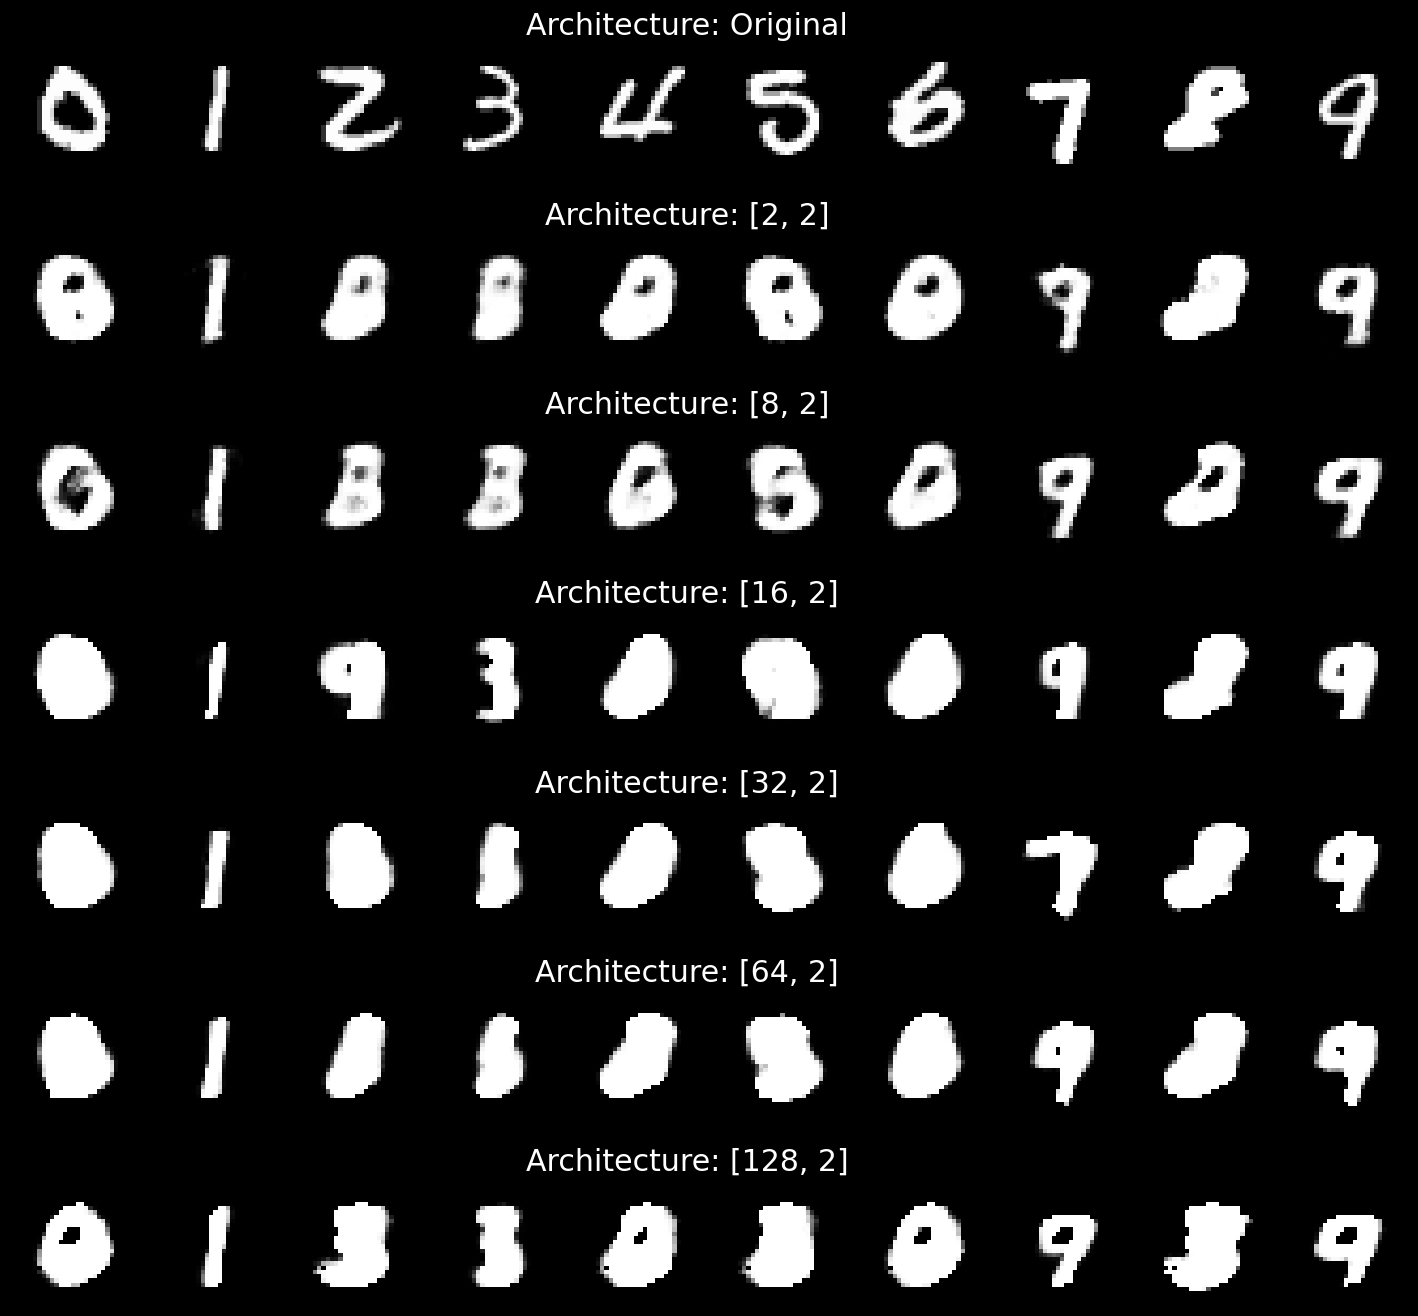

In [8]:
figure, _ = compare_generated_to_original_mnist(trained_models, mnist_test)
figure.savefig('./images/9.2_image_2.png');

In [10]:
latent_space_dict = get_dict_of_latent_spaces(trained_models, mnist_test)

100%|██████████| 40/40 [00:01<00:00, 25.48it/s]


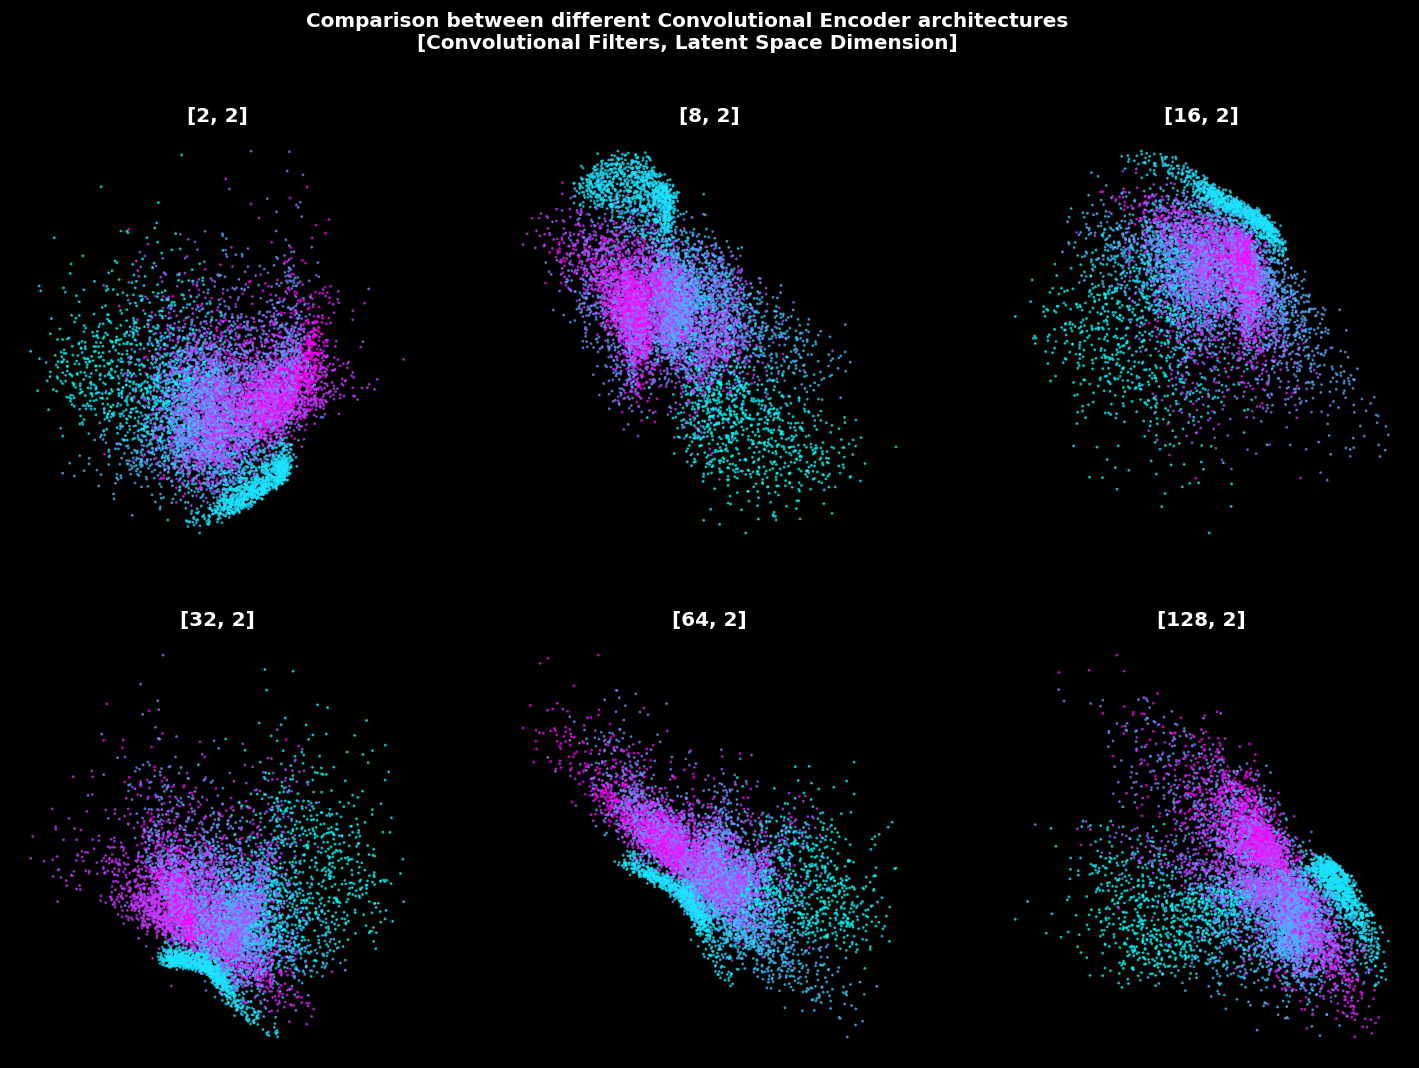

In [11]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
compare_latent_spaces(latent_space_dict, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'[Convolutional Filters, Latent Space Dimension]')
figure.savefig('./images/9.2_image_4.png');

Let's now repeat the calculation for latent space with 3 dimensions

In [12]:
latent_space_dim = 3
for num_filters in num_filters_list:
    architecture = [num_filters, latent_space_dim]
    print(f'{architecture}')
    
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=[num_filters],
        convolutional_kernels=[kernel_size],
        convolutional_strides=[stride],
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[2, 3]


100%|██████████| 25/25 [04:11<00:00, 10.04s/it, loss=0.659]


[8, 3]


100%|██████████| 25/25 [04:23<00:00, 10.52s/it, loss=0.635]


[16, 3]


100%|██████████| 25/25 [04:23<00:00, 10.53s/it, loss=0.625]


[32, 3]


100%|██████████| 25/25 [04:26<00:00, 10.65s/it, loss=0.628]


[64, 3]


100%|██████████| 25/25 [04:29<00:00, 10.79s/it, loss=0.658]


[128, 3]


100%|██████████| 25/25 [05:06<00:00, 12.28s/it, loss=0.641]


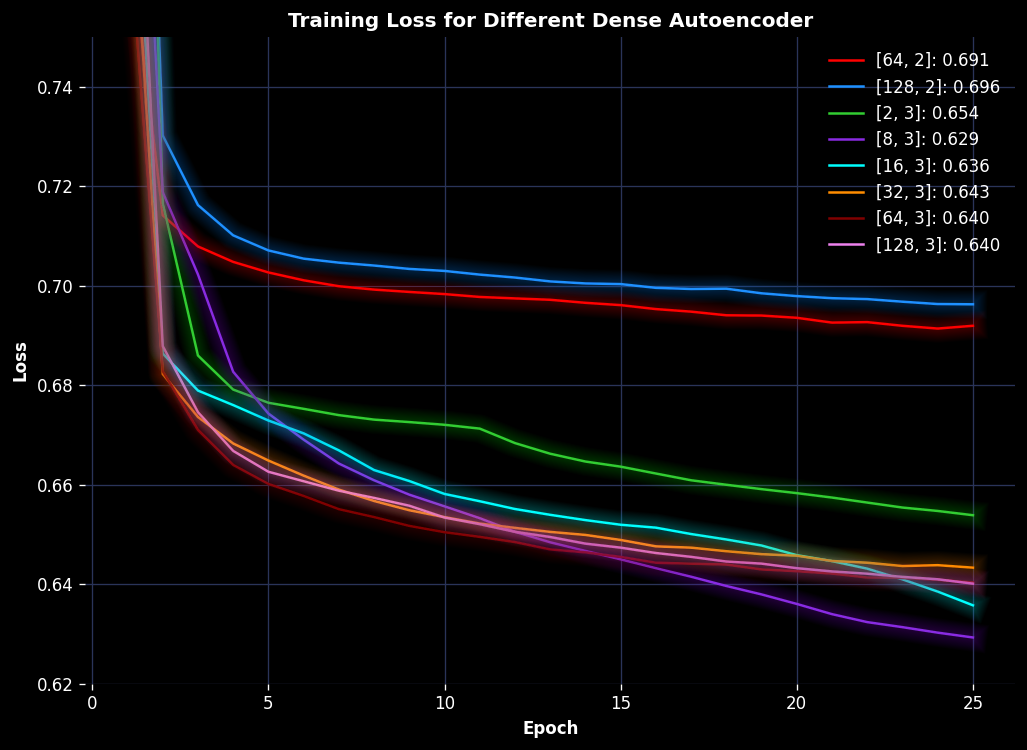

In [13]:
figure, axes = plt.subplots(1, 1, figsize=(10, 7))
config = dict(ylim=[0.62, 0.75])
plot_loss(epochs=NUM_EPOCHS,
          loss_dict=dict(list(loss_results.items())[-8:]),
          config_dict=config,
          title=f'Training Loss for Different Dense Autoencoder',
          ax=axes)
cp.make_lines_glow(ax=axes, n_glow_lines=15)
figure.savefig('./images/9.2_image_5.png');

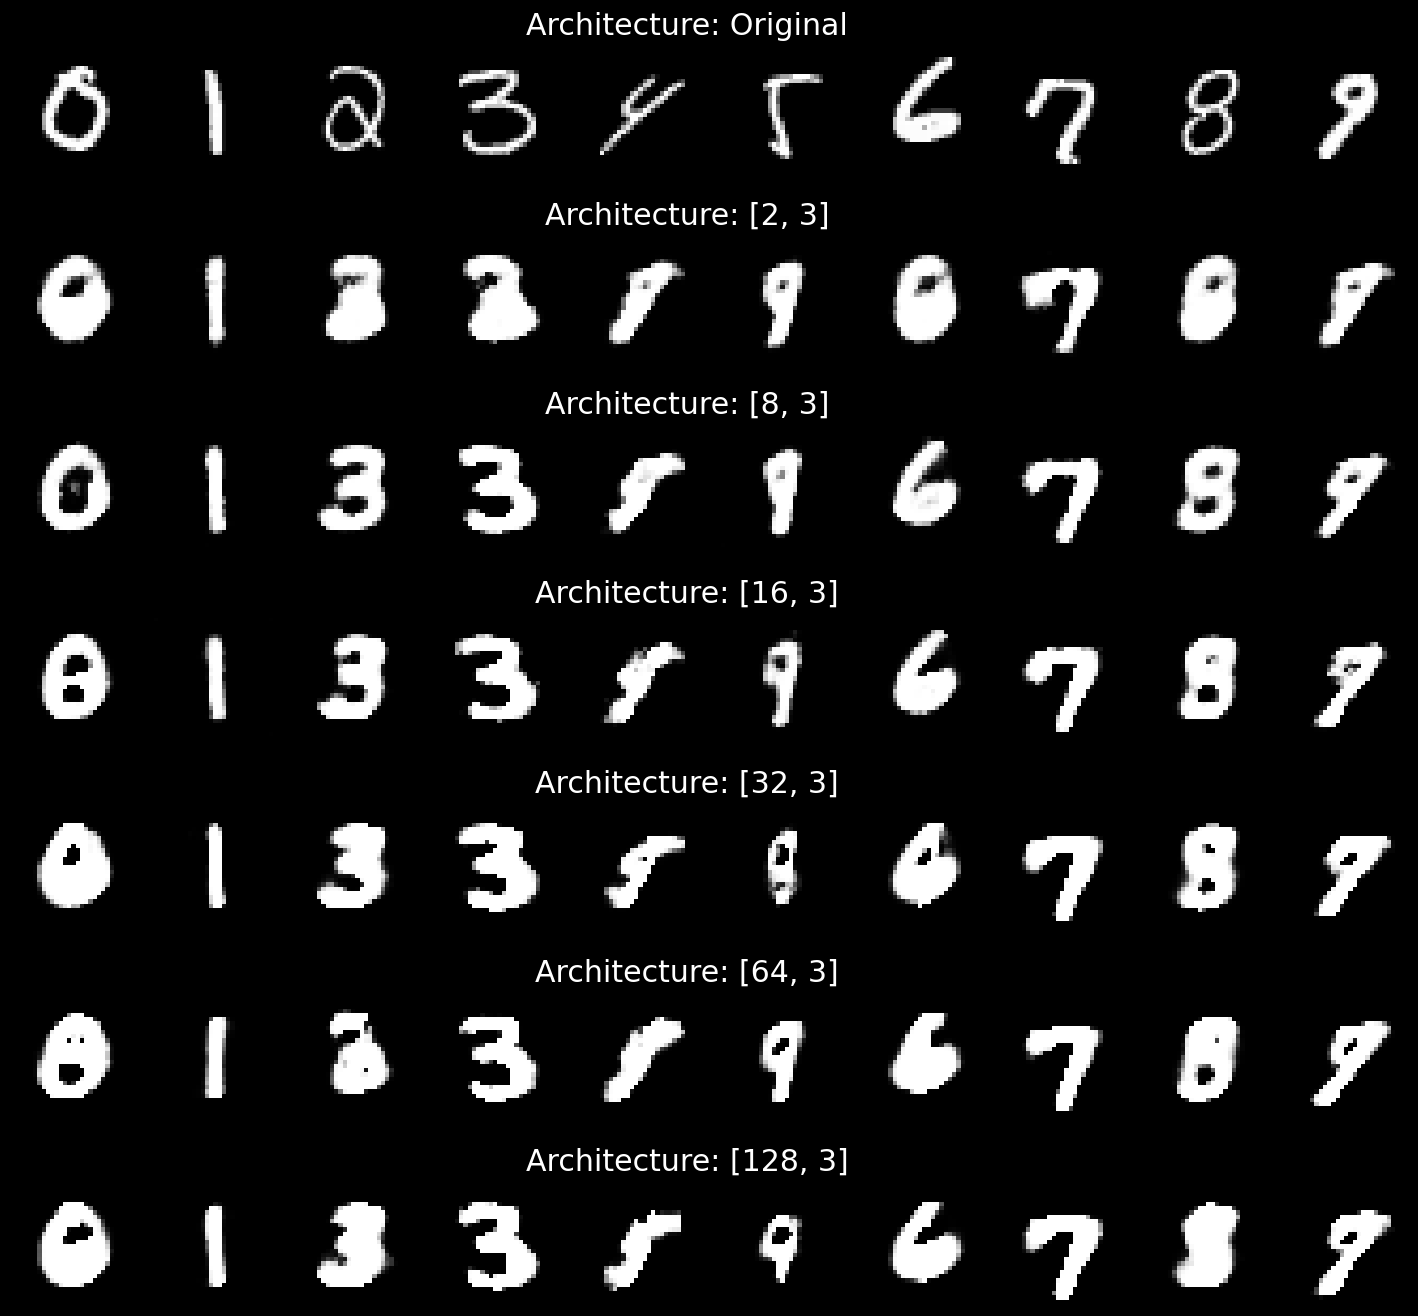

In [14]:
figure, _ = compare_generated_to_original_mnist(
    {name: model for name, model in trained_models.items() if '3]' in name}, 
    mnist_test)
figure.savefig('./images/9.2_image_6.png');

In [15]:
def compare_3d_latent_spaces(latent_space_dict, axes_list,
                             s=0.5, alpha=0.7, cmap='cool', zoom=0.85):
    for i, ((name, space), ax) in enumerate(zip(latent_space_dict.items(), axes_list.ravel()),
                                                  start=1):
        latent_points, labels = space
        ax.scatter(*latent_points, c=labels, s=s, alpha=alpha, cmap=cmap)
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_tick_params(which='major', color='black')
        ax.set(title=name)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlim(zoom_limits(latent_points[0], zoom_factor=zoom))
        ax.set_ylim(zoom_limits(latent_points[1], zoom_factor=zoom))
        ax.set_zlim(zoom_limits(latent_points[2], zoom_factor=zoom))

In [16]:
latent_space_dict = {
    **latent_space_dict,
    **get_dict_of_latent_spaces(
        {name: model for name, model in trained_models.items() if '3]' in name}, 
        mnist_test)
}

100%|██████████| 40/40 [00:01<00:00, 23.25it/s]


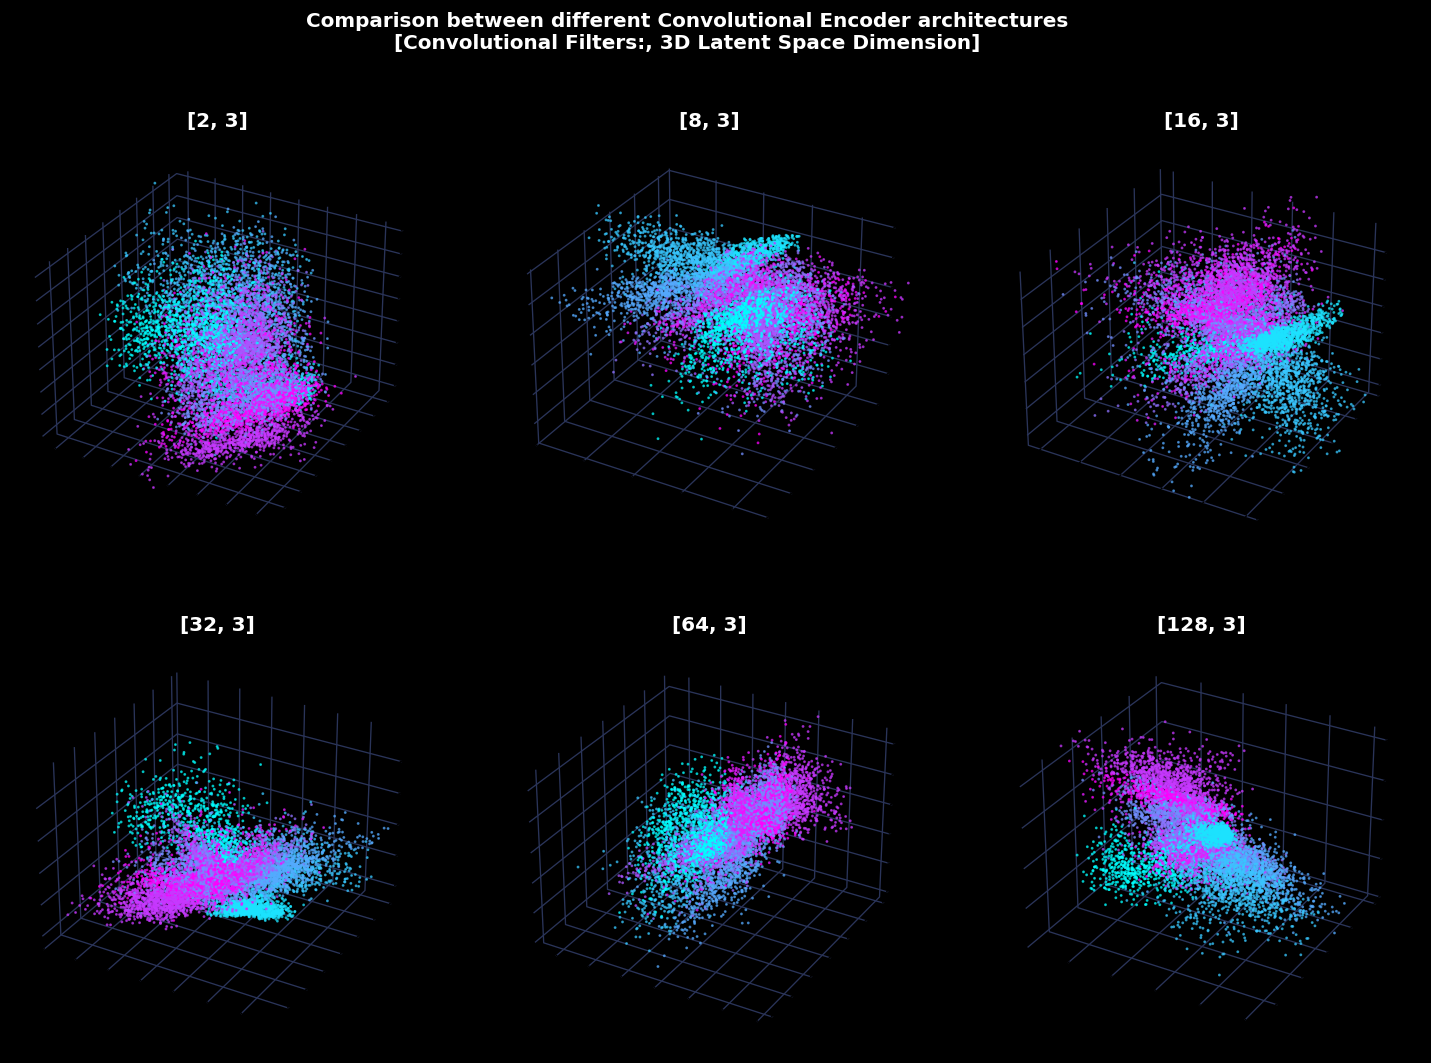

In [17]:
figure, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(projection='3d'))
compare_3d_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if '3]' in name}, axes)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'[Convolutional Filters:, 3D Latent Space Dimension]')
figure.savefig('./images/9.2_image_7.png');

Now Let's check how the depth of the network affects performance.

In [18]:
latent_space_dim = 3
num_filters_list = [[64, 64], [32, 32, 32, 32], [32, 64, 64, 32], [32, 64, 64, 64, 64, 32]]
for num_filters in num_filters_list:
    architecture = [*num_filters, latent_space_dim]
    print(f'{architecture}')
    
    n_convs = len(num_filters)
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=num_filters,
        convolutional_kernels=[kernel_size] * n_convs,
        convolutional_strides=[stride] * n_convs,
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[64, 64, 3]


100%|██████████| 25/25 [05:12<00:00, 12.50s/it, loss=0.582]


[32, 32, 32, 32, 3]


100%|██████████| 25/25 [05:11<00:00, 12.46s/it, loss=0.598]


[32, 64, 64, 32, 3]


100%|██████████| 25/25 [06:10<00:00, 14.84s/it, loss=0.614]


[32, 64, 64, 64, 64, 32, 3]


100%|██████████| 25/25 [10:14<00:00, 24.58s/it, loss=0.566]


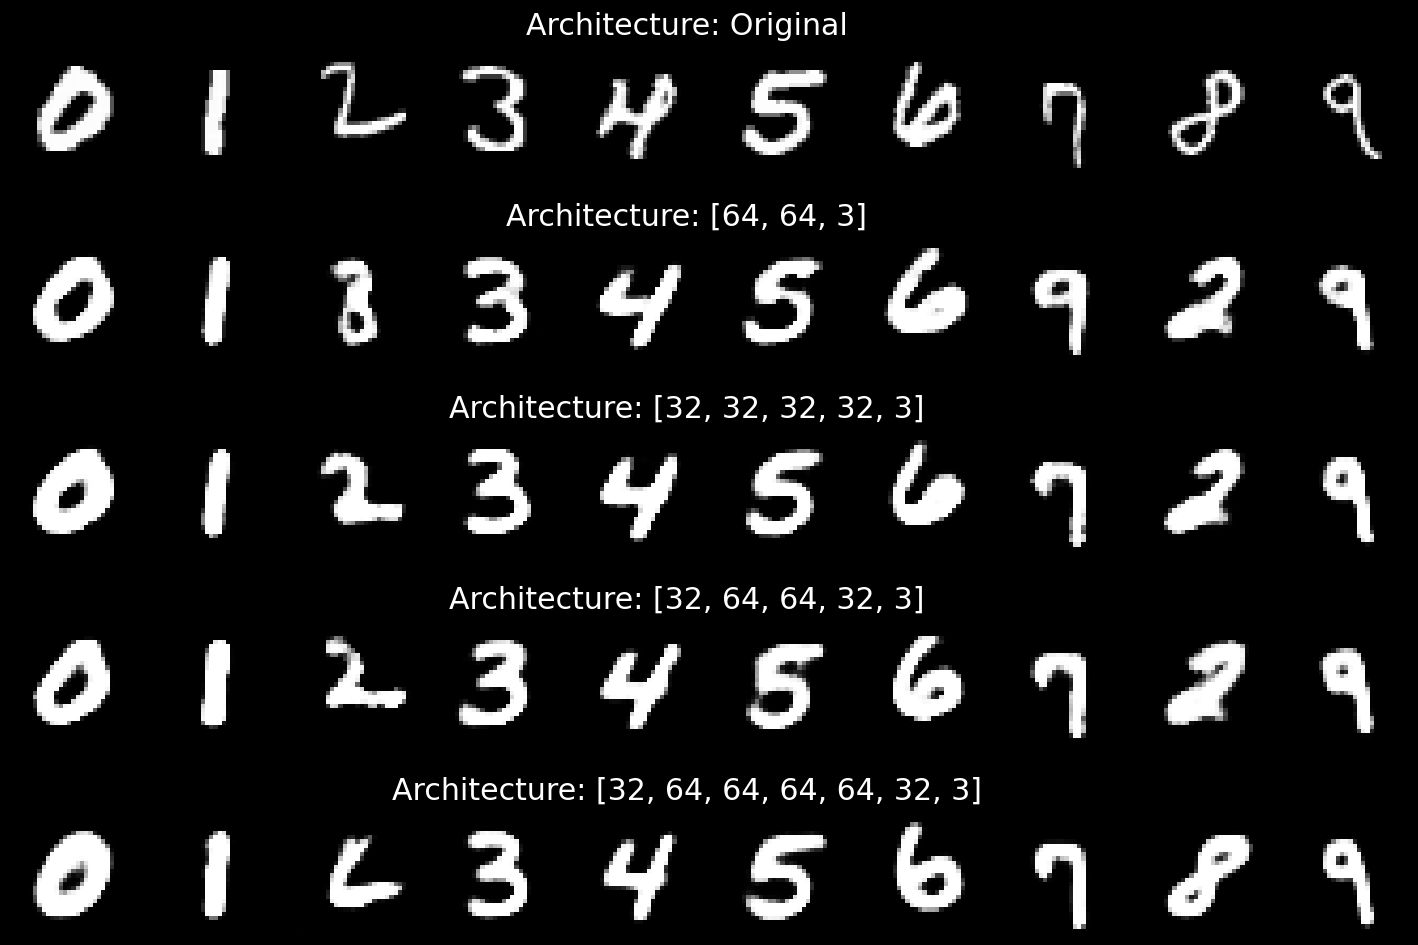

In [19]:
figure, _ = compare_generated_to_original_mnist(
    {name: model for name, model in trained_models.items() if len(eval(name)) > 2}, 
    mnist_test)
figure.savefig('./images/9.2_image_8.png');

Deeper convolutional layers managed to capture more insights and they don't confuse any digits. It is an impressive result considering the fact that the image was compressed to 3 numbers.

In [20]:
latent_space_dict = {
    **latent_space_dict,
    **get_dict_of_latent_spaces(
        {name: model for name, model in trained_models.items() if '3]' in name}, 
        mnist_test)
}

100%|██████████| 40/40 [00:02<00:00, 17.51it/s]


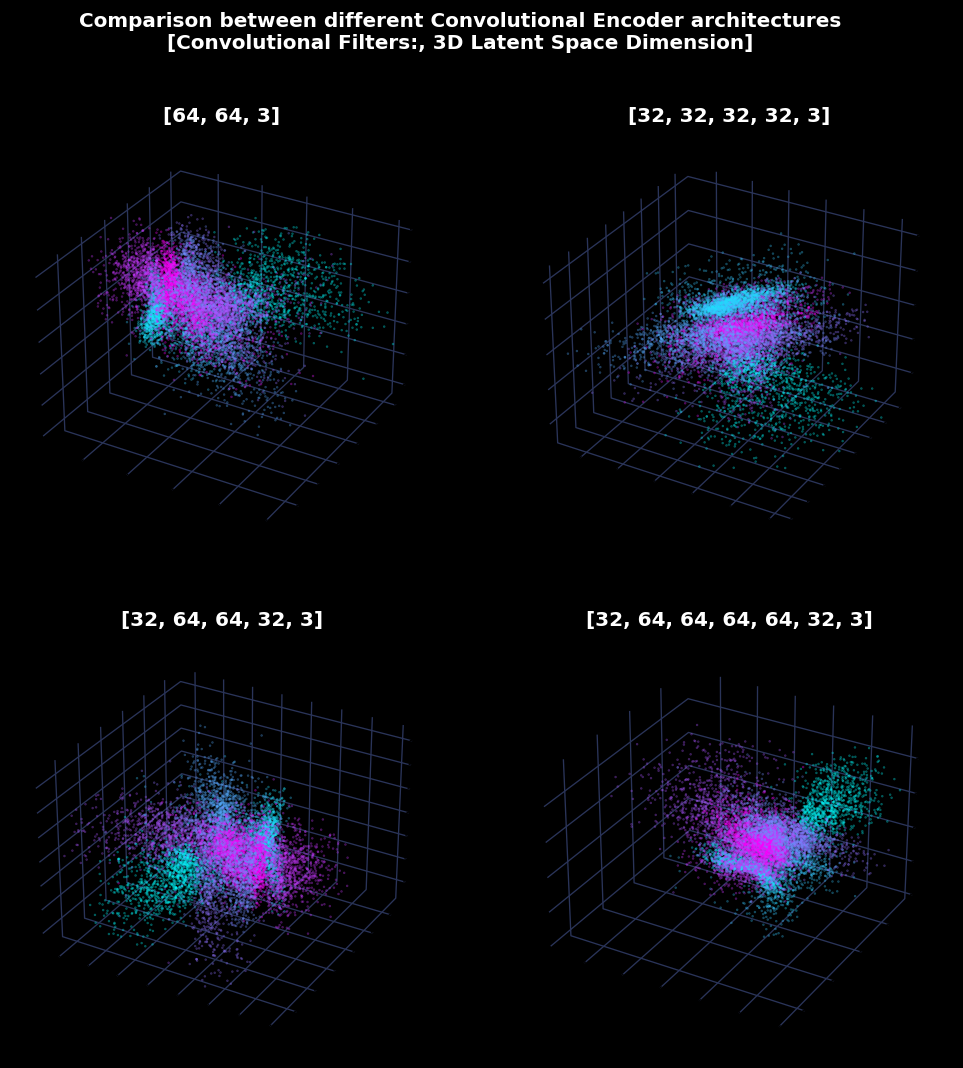

In [21]:
figure, axes = plt.subplots(2, 2, figsize=(10, 10), subplot_kw=dict(projection='3d'))
compare_3d_latent_spaces(
    {name: space for name, space in latent_space_dict.items() if len(eval(name)) > 2}, 
    axes, s=0.2, alpha=0.4)
figure.suptitle(f'Comparison between different Convolutional Encoder architectures\n'
                f'[Convolutional Filters:, 3D Latent Space Dimension]')
figure.savefig('./images/9.2_image_9.png');

Let's now take one of the deep architectures and check different latent space dimensions

In [22]:
latent_space_dim_list = [4, 16, 32, 64]
num_filters = [32, 64, 64, 32]
for latent_space_dim in latent_space_dim_list:
    architecture = [*num_filters, latent_space_dim]
    print(f'{architecture}')
    
    n_convs = len(num_filters)
    autoencoder = ConvolutionalAutoencoder(
        input_shape=INPUT_SHAPE,
        convolutional_filters=num_filters,
        convolutional_kernels=[kernel_size] * n_convs,
        convolutional_strides=[stride] * n_convs,
        latent_space_dimension=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[f'{architecture}'] = autoencoder

[32, 64, 64, 32, 4]


100%|██████████| 25/25 [06:11<00:00, 14.86s/it, loss=0.544]


[32, 64, 64, 32, 16]


100%|██████████| 25/25 [06:11<00:00, 14.88s/it, loss=0.481]


[32, 64, 64, 32, 32]


100%|██████████| 25/25 [06:12<00:00, 14.91s/it, loss=0.472]


[32, 64, 64, 32, 64]


100%|██████████| 25/25 [06:20<00:00, 15.23s/it, loss=0.469]


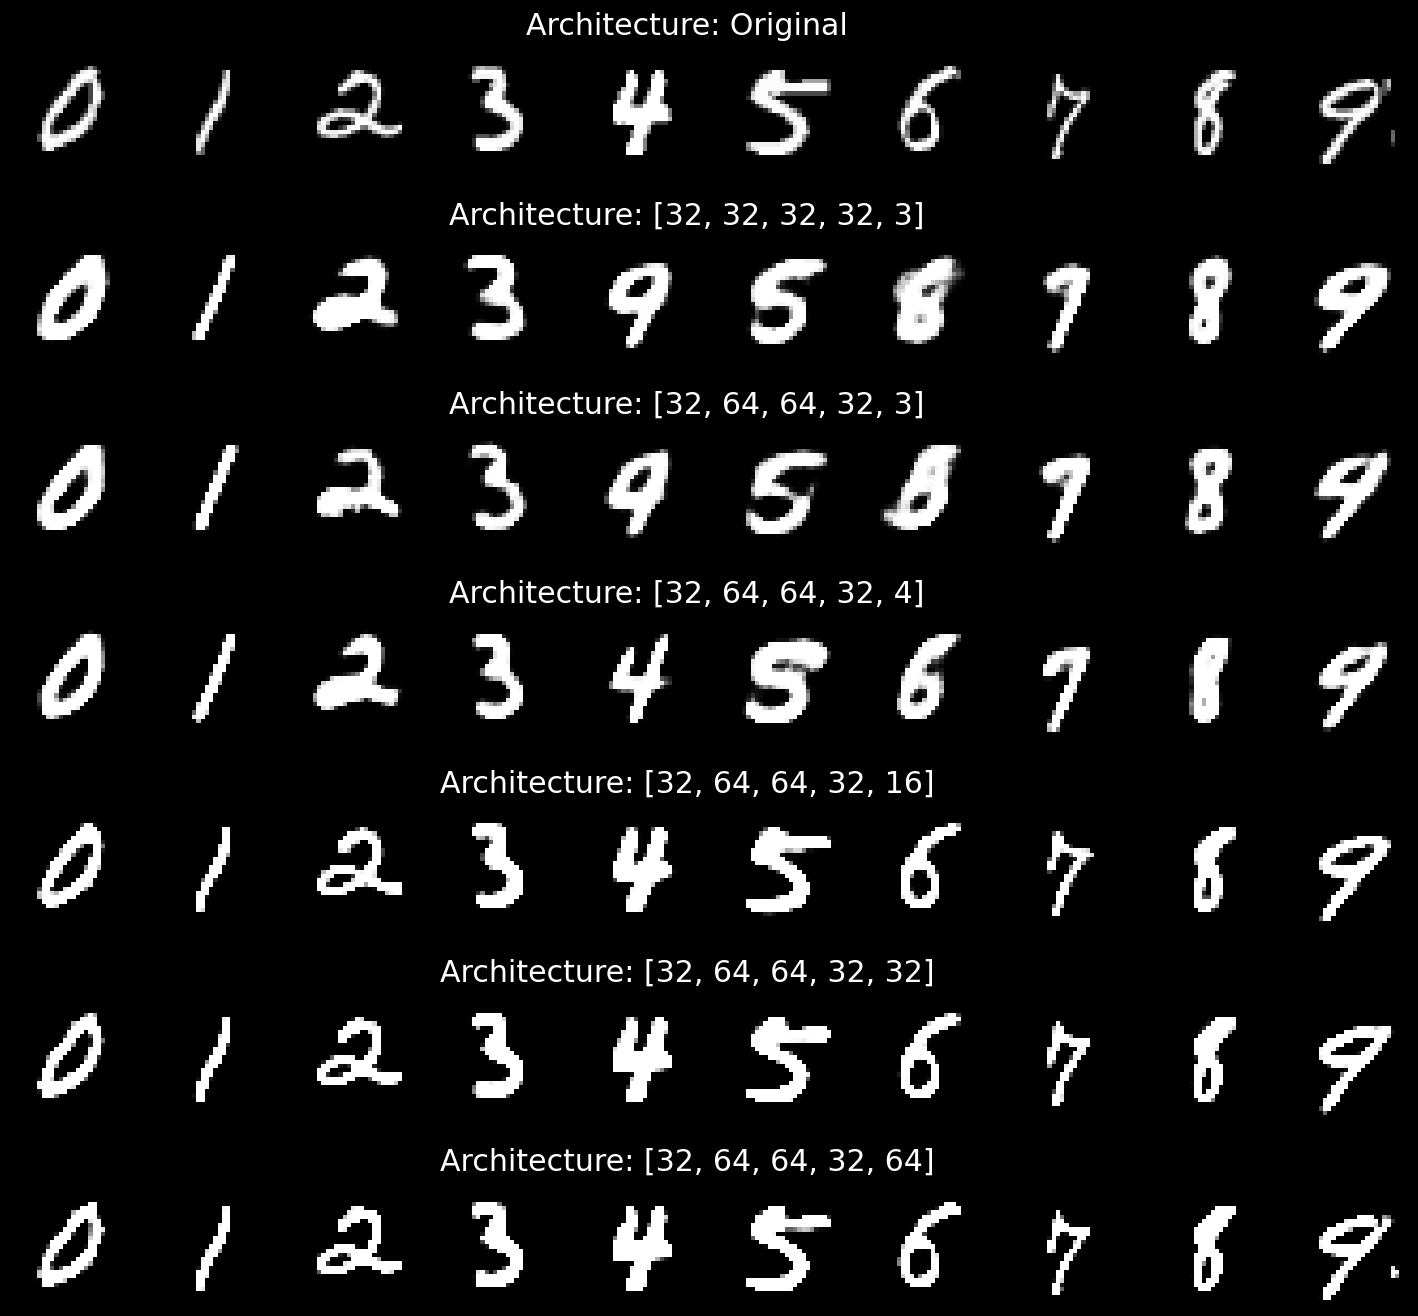

In [23]:
figure, _ = compare_generated_to_original_mnist(
    {name: model for name, model in trained_models.items() if len(eval(name)) == 5}, 
    mnist_test)
figure.savefig('./images/9.2_image_10.png');

In [ ]:
def compare_latent_spaces_projections(latent_space_dict, dataset, axes_list, reduced_dim=2,
                                      s=0.5, alpha=0.7, cmap='cool', zoom=0.85):
    for i, ((name, space), ax) in enumerate(zip(latent_space_dict.items(), axes_list.ravel()),
                                                  start=1):
        latent_points, labels = space
        ax.scatter(*latent_points, c=labels, s=s, alpha=alpha, cmap=cmap)
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_tick_params(which='major', color='black')
        ax.set(title=name)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xlim(zoom_limits(latent_points[0], zoom_factor=zoom))
        ax.set_ylim(zoom_limits(latent_points[1], zoom_factor=zoom))
        ax.set_zlim(zoom_limits(latent_points[2], zoom_factor=zoom))